# Explore ULS Fram data

## Read .pkl files

In [1]:
import os
import sys
import pickle
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
import datetime
import matplotlib.pyplot as plt

from src.utils import save_name

In [2]:
sys.path.append('/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_Fram/')

In [3]:
from read_thickness_PDF_and_output_ascii import main as read_fram

In [4]:
# Compute average mean sit and get time 
def get_sit_avg(pdf):
    ''' Draft = mean(number of values in each bin * bin value)
    '''
    
    values = []

    for i, n in enumerate(pdf.y_count):
        values.append([pdf.x_bin[i]]*n)

    draft_avg = np.mean(np.concatenate(values))
    draft_std = np.std(np.concatenate(values))
    
    # Draft to thickness
    # coefficient = 1.136 (from Sumata et al. 2023)

    sit_avg = draft_avg * 1.136
    sit_std = draft_std * 1.136
    
    # get time
    month = pdf.sampling_period[0]
    
    # get lat lon
    lat = pdf.lat
    lon = pdf.lon

    return sit_avg, sit_std, month, lat, lon




# Get files .pkl location 

In [5]:
idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_Fram/data_draft_PDF_range_0.0-8.0_bin0.1m/'

In [6]:
listfile = sorted(glob(os.path.join(idir,'*.pkl')))  # get all files

## Sites F11, F12, F13, F14

In [7]:
def list_for_site(list_files, site='F11'):
    '''Return files located at one site only
    
    Parameters:
    -----------
    
        list_files       : list of string. All .pkl files for ULS data
        site             : string. Location to used.
                            Can be: 'F11', 'F12', 'F13', 'F14'
    
    '''
    
    if site == 'F11':
        sensor = ['F11', '1990_sn03', '1991_sn03', '1992_sn13', '1999_sn32', '2002_sn48', '2004_sn55', '2005_sn51']  
    elif site == 'F12':
        sensor = ['F12', '1992_sn12', '1996_sn31', '1997_sn44', '1998_sn37', '1999_sn48', '2000_sn37']
    elif site == 'F13':
        sensor = ['F13', '1990_sn05', '1991_sn05', '1994_sn13', '1996_sn32', '1997_sn17', '1998_sn34', '1999_sn44', '2003_sn51']
    elif site == 'F14':
        sensor = ['F14', '1993_sn16', '1994_sn12', '1997_sn19', '1998_sn45', '1999_sn17', '2000_sn19', '2002_sn17', '2003_sn37', '2005_sn37']
    else:
        raise ValueError(f'Site does not exist. Got: {site}. Expects F11 to F14')
        
    clean_list = []
    
    for fname in list_files:
        if any(name in fname for name in sensor):
            clean_list.append(fname)
            
            
    return clean_list

In [8]:
site='F13'

In [9]:
# get files for one site only
list_site = list_for_site(listfile, site=site)

In [10]:
# Initialize global variables
sit_l = []
sit_std_l = []
chrono_l = []

lat_l = []
lon_l = []

## Loop on files

In [11]:
for fname in list_site:

    with open(fname, 'rb') as f:
        pdf = pickle.load(f) # pdf is uls_util.IceDraftPdf object
        sit_avg, sit_std, month, lat, lon = get_sit_avg(pdf)
        
    # put it in index
    sit_l.append(sit_avg)
    sit_std_l.append(sit_std)
    chrono_l.append(month)
    lat_l.append(lat)
    lon_l.append(lon)
        

## Convert list into array with nan 

In [12]:
# dataset spans from datemin to datemax on all 4 sites
datemin = datetime.datetime(1990, 8, 1)
datemax = datetime.datetime(2019, 9, 1)

# First day of month, for each month between datemin and datemax
chrono_dt = np.array(pd.date_range(datemin, datemax, freq='MS').to_pydatetime().tolist())
sit = np.ones((chrono_dt.shape)) * -999
sit_std = np.ones((chrono_dt.shape)) * -999
lat = np.ones((chrono_dt.shape)) * -999
lon = np.ones((chrono_dt.shape)) * -999


# Array contenaining all months is filled with list
for i, month in enumerate(chrono_l):
    idx = np.where(chrono_dt==month)[0][0]
    sit[idx] = sit_l[i]
    sit_std[idx] = sit_std_l[i]    
    lat[idx] = lat_l[i]    
    lon[idx] = lon_l[i]    

## Save as .netcdf

In [13]:
osit = xr.DataArray(sit, 
                coords={'time': chrono_dt},
                dims=["time"],
                attrs={'name':'sit',
                       'long_name':'mean sea ice thickness',
                       'unit':'m',
                      })

In [14]:
osit_std = xr.DataArray(sit_std, 
                coords={'time': chrono_dt}, 
                dims=["time"],
                attrs={'name':'sit_std',
                       'long_name':'sea ice thickness standard deviation',
                       'unit':'m',
                      })

In [15]:
olat = xr.DataArray(lat, 
                coords={'time': chrono_dt}, 
                dims=["time"],
                attrs={'name':'latitude',
                       'unit':'North'
                      })

In [16]:
olon = xr.DataArray(lon, 
                coords={'time': chrono_dt}, 
                dims=["time"],
                attrs={'name':'longitude',
                       'unit':'East'
                      })

In [17]:
ods = xr.Dataset(data_vars={'sit':    osit,
                            'sit_std':osit_std,
#                             'sit_min':osit_min,
#                             'sit_max':osit_max,
                            'lat':    olat,
                            'lon':    olon
                           },
                   attrs=dict(
                       description='Monthly Timeseries of SIT from ULS Fram',
                       years=f'from {datemin.year} until {datemax.year}',
                       mooring=f'{site.upper()}',
                       author='Leo Edel, Nersc',
                       project='TARDIS',
                       date=f'{datetime.date.today()}')
                  )

In [18]:
odir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_Fram/netcdf/'

In [19]:
filename = f'ULS_{site}_Sumata_SITm_{datemin.year}_{datemax.year}.nc'

In [20]:
# ofile = save_name.check(f"{odir}", filename)
ods.to_netcdf(f'{odir}{filename}')
print(f'Netcdf saved as: {odir}{filename}')

Netcdf saved as: /scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_Fram/netcdf/ULS_F13_Sumata_SITm_1990_2019.nc


## Plot

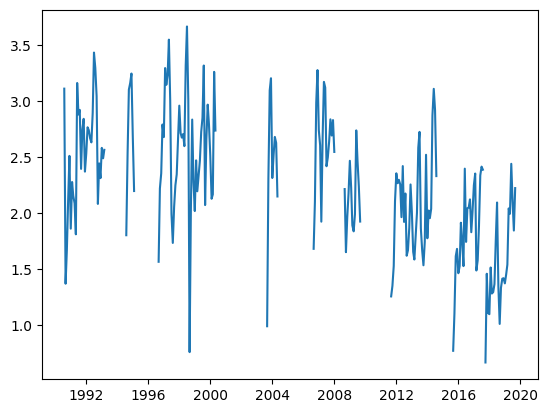

In [21]:
plt.plot(chrono_dt, osit.where(osit>0))

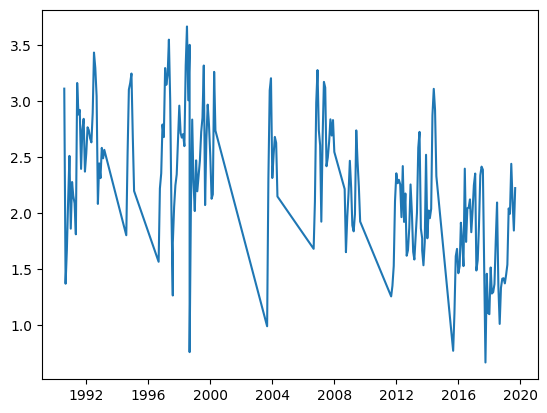

In [22]:
plt.plot(chrono_l, sit_l)

In [23]:
#chrono_l

In [24]:
## Read file with script given by Sumata
# read_fram(idir+'draft_pdf_2019.09.1047_F14-20_201809_201909_p01_draft_FINAL_ASCII.dat.pkl')